# Transport through donor chains

This notebook is intended to be a set of example calculations for anyone using my quantum transport code (creatively names "Fermi-Hubbard Transport Solver"). It's written with transport through a 1D chain of donors in mind, though it can in principle handle any system with a small enough set of interacting for your computer to solve for the eigenstates of exactly (note that in the case of donors, for $n$ donors the difficulty of doing so with this code scales as $\mathcal{O}(4^n)$, so start small and work your way up to see what your computer can handle).

##### Standard FH Hamiltonian:
To start with, the Fermi-Hubbard Hamiltonian is a relatively natural fit for donors in Si. The donors typically act as individual sites that electrons can stay on, with typically no more than two staying on any individual donor at a time. Then, if these donors are spread far enough apart, electrons can typically only hop between sites that are nearest neighbors (this won't be a restriction in our calculations, though). If we have a perfectly evenly spaced grid (in however many dimensions you want, though this notebook will largely focus on a 1D chain), the resulting Hamiltonian is
\begin{equation}
\hat{H}_ {FH}=(\epsilon-\mu_\circ)\sum_\sigma\sum_j\hat{n}_ {j\sigma}+t\sum_\sigma\sum_{\langle j,k\rangle}\left(\hat{c}_ {j\sigma}^\dagger\hat{c}_ {k\sigma}+\hat{c}_ {k\sigma}^\dagger\hat{c}_ {j\sigma}\right)+U\sum_j\hat{n}_ {j\uparrow}\hat{n}_ {j\downarrow},
\end{equation}
where $\epsilon$ is the binding energy of a single electron onto an individual donor, $2\epsilon+U$ is the energy to have two electrons on a single donor (making $U$ the repulsion energy), $\mu_\circ$ is the chemical potential, and $t$ is the tunneling rate between donors $j$ and $k$ if they're neighbors, denoted by $\langle j,k\rangle$ in the sum.

While this is a great approximation for Hamiltonian of the donors, there are a few shortcomings. For example, a paper by Le, Fisher, and Ginossar (https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.155306) points out that the repulsion between nearest neighbors matters a lot. And in the calculations I have done, I see that the next nearest neighbor hoppings can make a difference, too. For simplicity, we'll be including the next-nearest neighbor hopping, but not the extra nearest neighbor repulsion terms. Both matter for the most exact description of the system of donors, but there is a lot to say without the extra features. In principle, our Hamiltonian can include hopping arbitrary distances down the chain, though the dropoff in tunneling rates localizes this a little. (Note that the extra repulsions can actually be added easily enough, utilizing the number operators that the code provides.)

##### Meir-Wingreen formula:
This code uses something called the Meir-Wingreen formula to calculate the current through our donor chains (or whatever you're focused on). The current flowing from the left lead $L$ to a finite region $q$ in steady state can be written with Green's functions can be shown to be
\begin{equation}
I_L(t)=\eta_I\mathrm{Tr}\left\{\hat{h}_ {Lq}\hat{G}^<_ {qL}(t,t)-\hat{h}_ {qL}\hat{G}^<_ {Lq}(t,t)\right\},
\end{equation}
where $I_L$ is the current, $t$ is the time (though a steady-state current shouldn't change with time, hence why we're using equal-time Green's functions), $\hat{h}_ {Lq/qL}$ is the part of the Hamiltonian that couples the lead and finite region, $\hat{G}^<_ {Lq/qL}(t,t)$ is the lesser Green's function connecting the two regions, and $\eta_I$ is just a conversion factor for switching between a rate of change of a number of charge carriers to a current. (The above formula can be derived using a second quantized version of the continuity equation and considering that the current is the time rate of change of the total number of electrons in either lead.) Knowing some things about Green's functions though (Langreth rules especially), one can rewrite this (halfway) in the Meir-Wingreen formula as
\begin{equation}
I_L=\eta_I\mathrm{Tr}\left\{\hat{h}_ {Lq}\hat{G}^<_ {qL}(t,t)\right\}-\eta_I\int\!d\omega\,\mathrm{Tr}\left\{\hat{\Sigma}_ L^<(\omega)\hat{G}_ q^A(\omega)+\hat{\Sigma}_ L^R(\omega)\hat{G}_ q^<(\omega)\right\},
\end{equation}
where the $\hat{\Sigma}$ terms are embedding self-energies with the leads. (Note: the full MW formula also transforms $\hat{h}_ {Lq}\hat{G}^<_ {qL}(t,t)$ into an integral in frequency space, quite similar to how $\hat{h}_ {qL}\hat{G}^<_ {Lq}(t,t)$ was transformed. I just left it this way because it's a little shorter.)

##### Our self-energy approximation (and what it lacks):
So far, the Meir-Wingreen formula the way we've written it is *exact* $-$ that is, if you have the exact Green's functions, which are (probably) in general QMA-complete to calculate (at least in terms of the ground-state Green's functions, since the main difficulty in doing that calculation is getting the ground state; general thermal state Green's functions are either a little harder or easier, depending on the temperature). So we have to approximate our Green's functions, and we do so using a pretty cheap self-energy approximation.

Note that the approximation we take for including the embedding self-energy is
\begin{equation}
\hat{G}_ q(\omega)\approx\frac{1}{\omega-{\hat{G}_ {\circ,q}(\omega)}^{-1}-\hat{\Sigma}_ {em}(\omega)},
\end{equation}
where $\hat{G}_ {\circ,q}(\omega)$ is the Green's function of our chain without the presence of the leads and $\hat{\Sigma}_ {em}(\omega)$ is specifically the embedding self-energy one would have from the leads if there were no electron interactions. This equates to the assumption that interaction and embedding self-energies are additive, which I don't believe is true $-$ if it were, the Anderson impurity model would be nearly trivial to solve, at least numerically speaking. Thus while the Meir-Wingreen formula is exact, our inputs to it are only approximated, meaning that some details of the system get left out. Not only that, but we also take the wide-band approximation, which here amounts to saying
\begin{equation}
\frac{d}{d\omega}\hat{\Sigma}_ {em}(\omega)=0.
\end{equation}
While all of this clearly will leave our calculations inexact, nevertheless this approximation can still give us some sense of what we should expect to see, because one would expect that if the coupling to the leads is weak enough then the majority of the interesting things happening in these donor chains will come from the electron interactions on the chains rather than the embedding with the leads.

>**Note**: The tunnel couplings used in this notebook (first pointed to in `sTunnel_file`) are from the supplementary material in the paper https://journals.aps.org/prb/abstract/10.1103/PhysRevB.91.235318, from the file named `tunnelCouplings.txt`. If you want to use different tunnel couplings, you can definitely do so! Just define `matTs` and `matGammaL`/`matGammaR` with the different tunnel couplings you want to use.

# Example calculations

And now that I've given a brief description of the calculations, let's go through a few examples!

## Setting up general things

This first cell below here is just for the sake of importing the code (which I do as executing a Python file instead of having some actual import statement $-$ probably not the *best* coding practice, but it works, so...), as well as including a file of tunnel couplings (see above).

Note that you'll have to adjust `'/Users/mbricks/Documents/python_scripts/transport_FH.py'` to whatever your path to the code is, and `'/Users/mbricks/Documents/tunnelCouplings.txt'` will have to be adjusted to wherever you have a tunnel coupling file (or excluded and replaced throughout with some other parameterization, if you have other things you want to do).

The second cell defines some other parameters, e.g. the on-site repulsion and on-site energy in `rU_eV` and `rE_eV`, which are taken from https://www.nature.com/articles/s41534-017-0051-1, or the neutral chemical potential, `rm_eV`, decided by a trial-and-error search for a chemical potential that puts most 1D chains at half filling.

In [1]:
%pylab inline
%matplotlib inline
exec(open('/Users/mbricks/Documents/python_scripts/transport_FH.py').read())
import warnings
warnings.filterwarnings("ignore")
print('Loading the tunnel coupling file.')
print(datetime.datetime.now())
sTunnel_file = '/Users/mbricks/Documents/tunnelCouplings.txt'
raTunnel_raw = loadtxt(sTunnel_file ,skiprows=5)
from scipy.interpolate import NearestNDInterpolator
print(datetime.datetime.now())
fTunnel = NearestNDInterpolator(raTunnel_raw[:,:3],raTunnel_raw[:,3])
print(datetime.datetime.now())

Populating the interactive namespace from numpy and matplotlib
Loading the tunnel coupling file.
2021-01-25 15:17:09.492019
2021-01-25 15:17:16.376138
2021-01-25 15:17:17.546259


In [2]:
rE_eV = 90.0e-3
rU_eV = 75.0e-3
rm_eV = 1.25*rE_eV
rBeta_eVinv = 1./(8.617e-5)
# Size of a unit cell in Si
raLatticeConstant = np.array([0.5431,0.,0.])
# Number of lattice sites for spacing
nLatticeSites = 5
# Full intended distance between donors
raR_nm = nLatticeSites*raLatticeConstant
# Tunneling rate
rt_eV = 1.0e-3*fTunnel(raR_nm)[0]
# Number of on-site energies to do calculations for.
nEs = 101
# Number of biases to calculate currents for.
nIs = 101
# Number of time points to sample
nPts = 10001
# Maximum time for the time sampling
rTmax = 50./rt_eV
# Array of on-site energies
raErange_eV = np.linspace(-0.5*rE_eV,2.*rE_eV,nEs)
# Broadening parameter for frequency domain Green's functions
rEta_eV = 0.0005
# Set of $\omega$ values at which to calculate the Green's functions
# (written as `ftTimes` for the Fourier transform of the time domain)
ftTimes = np.linspace(-0.2*rm_eV,0.2*rm_eV,nPts)*2.*np.pi
# Array of the biases across the chain
raBias_eV = np.linspace(-0.2*rm_eV,0.2*rm_eV,nIs)*2.*np.pi

## Transport through a single donor

The first example is the simplest thing we can imagine, for the things we want to consider, running a current through just a single donor. This will lead us through everything needed to run a calculation of the current as a function of two parameters, the bias across the chain (labeled as $\mu$ in the plots below, defined above in the code in the array `raBais_eV`) and the effective on-site energy (labeled as $\epsilon$ in the plots below, defined above in the code in the array `raErange_eV`), which can be controlled by electrostatic gates layered on top of (or somewhere near) the donors in question. (Note if you want the conductance just as a function of the bias, there's a function `gcalcDoubleBiasSweep` that's similar to the function used below, or you could just take a slice of the 2D calculation if you're willing to wait for it).

Note that while `gcalcDoubleBiasSweep` actually calculates the current, what I plot below is the differential conductance, $dI/d\mu$, because that's a plot that tends to be easier to read (at least for me). In particular, it's typically the case that each line on a plot like this corresponds to a particular charge transition on the chain, e.g. taking a slice at constant $\epsilon$ gives peaks where a new state is included in the bias window, or taking a slice at constant $\mu$ shows peaks where the change in the nearby gate voltage pushes off or pulls on extra electrons.

In [3]:
'''
This first set of functions is all for the sake of defining any needed inputs to the calculation
function, `gcalcDoubleBiasSweep`, that aren't already defined above, mostly in terms of `matTs`,
a matrix of all the tunnel couplings between donors in the current system (which is empty for a
single donor), and `matGammaL`/`matGammaR`, which hold the tunnel couplings to the left and right
leads. These are all the things you would really need to change for a different system (assuming
you're okay with using the same on-site energies and repulsions as we do here).
'''
# Define the number of donors
nDonors = 1
# Allocate space for the tunnel couplings
matTsNow = np.zeros([nDonors,nDonors])
raGammasL = np.zeros([nDonors])
raGammasR = np.zeros([nDonors])
# Fill in all the tunnel couplings (if you want to use different tunnel couplings, this
# is mostly where you'd change things)
for jIdx in np.arange(nDonors):
    raGammasL[jIdx] = (1.0e-3*fTunnel((jIdx+1)*raR_nm)[0])**2
    raGammasR[-1-jIdx] = (1.0e-3*fTunnel((jIdx+1)*raR_nm)[0])**2
    for kIdx in np.arange(nDonors):
        nDist = np.abs(jIdx-kIdx)
        if int(nDist)!=0:
            matTsNow[jIdx,kIdx] = 1.0e-3*fTunnel(nDist*raR_nm)[0]
# Here's where I define the matrices for the embeddings
matGammaL = np.kron(np.diag(raGammasL),np.eye(2,dtype=np.complex128))
matGammaR = np.kron(np.diag(raGammasR),np.eye(2,dtype=np.complex128))


# And now actually calculate! Mix and match inputs here to adjust calculations as you need
# (hopefully it's obvious enough what to do from here, but the actual function in the code
# will have comments in the description if this isn't enough)
raCurrents2D_1donor = gcalcDoubleBiasSweep(matTsNow,matGammaL,matGammaR,raErange_eV,rm_eV,rU_eV,\
                                           raBias_eV,ftTimes,rEta_eV,rBeta_eVinv,1,nTrack=None)

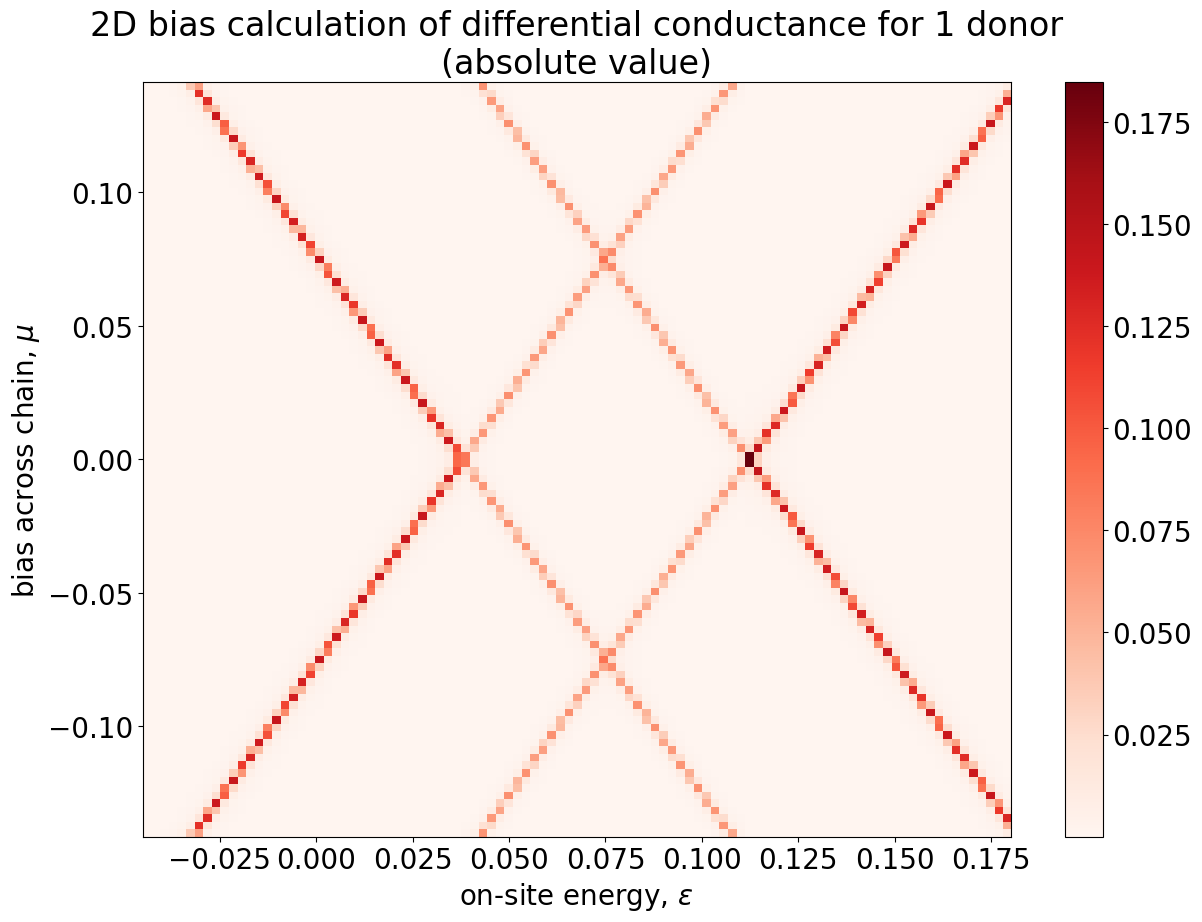

In [4]:
rcParams.update({'font.size': 20})
figure(figsize=(14,10),dpi=100)
raLims = [raErange_eV[0],raErange_eV[-1],raBias_eV[0],raBias_eV[-1]]
radIdV = (raCurrents2D_1donor[:nIs-1,:]-raCurrents2D_1donor[1:,:])/\
         (raBias_eV[1]-raBias_eV[0])
imshow(np.abs(radIdV),extent=raLims,cmap='Reds',aspect='auto')
title('2D bias calculation of differential conductance for 1 donor\n(absolute value)')
xlabel(r'on-site energy, $\epsilon$')
ylabel(r'bias across chain, $\mu$')
colorbar()

In that plot above for a single donor, you can see what's called a Coulomb diamond. This is a typical signature of the abrupt transitions between the total number of electrons you have on a donor (or quantum dot, or similarly small island of charge). On the left-most side of the plot, you can imagine that with such a low on-site energy, we start with two electons on our donor, and we drive a current with the bias when the bias is large enough to take an individual electron off the donor. But as we move to the right, the on-site energy eventually gets large enough that the on-site repulsion overpowers it and you only have one electron on the donor at a time. At first, when you've increased the on-site energy just enough for this to happen, the bias drives a current by flowing electrons through the state that the other electron was just kicked out of, and of course the more that the on-site energy is increased, the larger of a bias you need to get that current. But eventually after increasing that on-site energy so much it becomes easier to kick the second electron off tto get a current, and a smaller bias is needed, all the way until that electron is kicked off by having too high of an on-site energy. This is what creates the rhombus shape that we call the Coulomb diamond, and in systems with more donors, you'll see many of these diamonds lined up next to each other, with varying widths and heights depending on the details of the interactions in the system.

## Transport through a longer chains

In fact, we can easily show those Coulomb diamonds next to each other! Below we have calculations of transport through 2 and 3 donors - for the latter case, there are calculations for what the transport signatures look like if you include all the tunnel couplings in the system (the first plot for the 3 donor calculations) and what it looks like if you only include nearest neighbor hoppings.

In [5]:
nDonors = 2
# Allocate space for the tunnel couplings
matTsNow = np.zeros([nDonors,nDonors])
raGammasL = np.zeros([nDonors])
raGammasR = np.zeros([nDonors])
# Fill in all the tunnel couplings (if you want to use different tunnel couplings, this
# is mostly where you'd change things)
for jIdx in np.arange(nDonors):
    raGammasL[jIdx] = (1.0e-3*fTunnel((jIdx+1)*raR_nm)[0])**2
    raGammasR[-1-jIdx] = (1.0e-3*fTunnel((jIdx+1)*raR_nm)[0])**2
    for kIdx in np.arange(nDonors):
        nDist = np.abs(jIdx-kIdx)
        if int(nDist)!=0:
            matTsNow[jIdx,kIdx] = 1.0e-3*fTunnel(nDist*raR_nm)[0]
# Here's where I define the matrices for the embeddings
matGammaL = np.kron(np.diag(raGammasL),np.eye(2,dtype=np.complex128))
matGammaR = np.kron(np.diag(raGammasR),np.eye(2,dtype=np.complex128))


# And now actually calculate! Mix and match inputs here to adjust calculations as you need
raCurrents2D_2donors = gcalcDoubleBiasSweep(matTsNow,matGammaL,matGammaR,raErange_eV,rm_eV,rU_eV,\
                                            raBias_eV,ftTimes,rEta_eV,rBeta_eVinv,3,nTrack=10)

0 2021-01-25 15:17:35.419467
10 2021-01-25 15:17:41.574945
20 2021-01-25 15:17:47.987222
30 2021-01-25 15:17:54.398205
40 2021-01-25 15:18:01.018301
50 2021-01-25 15:18:07.060820
60 2021-01-25 15:18:13.399350
70 2021-01-25 15:18:19.656885
80 2021-01-25 15:18:26.072580
90 2021-01-25 15:18:32.256804
100 2021-01-25 15:18:38.759148


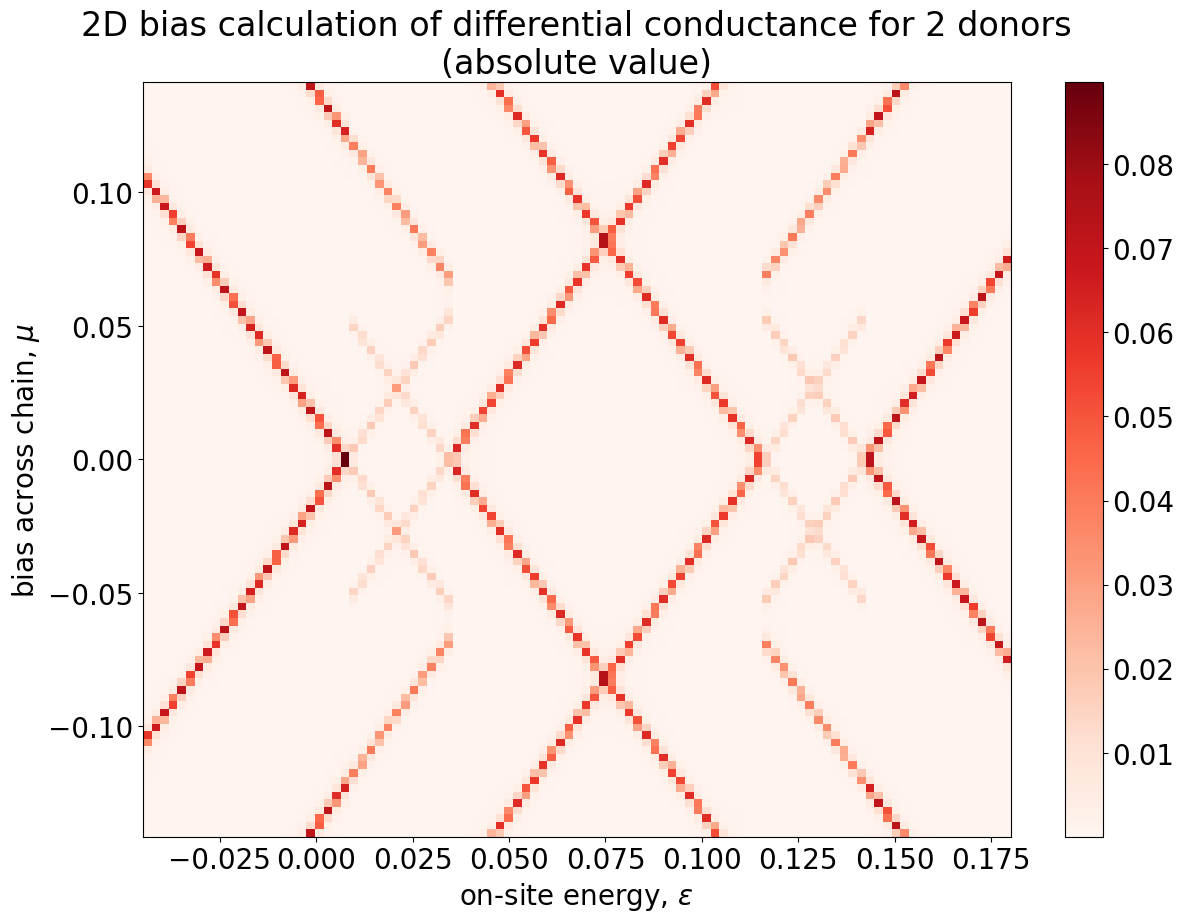

In [6]:
figure(figsize=(14,10),dpi=100)
raLims = [raErange_eV[0],raErange_eV[-1],raBias_eV[0],raBias_eV[-1]]
radIdV = (raCurrents2D_2donors[:nIs-1,:]-raCurrents2D_2donors[1:,:])/\
         (raBias_eV[1]-raBias_eV[0])
imshow(np.abs(radIdV),extent=raLims,cmap='Reds',aspect='auto')
title('2D bias calculation of differential conductance for 2 donors\n(absolute value)')
xlabel(r'on-site energy, $\epsilon$')
ylabel(r'bias across chain, $\mu$')
colorbar()

In the above calculation, you can see the Coulomb diamonds associated with having 3, 2, and 1 electrons on the chain (with "half-diamonds" on the left and right corresponding to haing 4 and 0 electrons on the donors, respectively).

In [7]:
nDonors = 3
# Allocate space for the tunnel couplings
matTsNow = np.zeros([nDonors,nDonors])
raGammasL = np.zeros([nDonors])
raGammasR = np.zeros([nDonors])
# Fill in all the tunnel couplings (if you want to use different tunnel couplings, this
# is mostly where you'd change things)
for jIdx in np.arange(nDonors):
    raGammasL[jIdx] = (1.0e-3*fTunnel((jIdx+1)*raR_nm)[0])**2
    raGammasR[-1-jIdx] = (1.0e-3*fTunnel((jIdx+1)*raR_nm)[0])**2
    for kIdx in np.arange(nDonors):
        nDist = np.abs(jIdx-kIdx)
        if int(nDist)!=0:
            matTsNow[jIdx,kIdx] = 1.0e-3*fTunnel(nDist*raR_nm)[0]
# Here's where I define the matrices for the embeddings
matGammaL = np.kron(np.diag(raGammasL),np.eye(2,dtype=np.complex128))
matGammaR = np.kron(np.diag(raGammasR),np.eye(2,dtype=np.complex128))


# And now actually calculate! Mix and match inputs here to adjust calculations as you need
raCurrents2D_3donors = gcalcDoubleBiasSweep(matTsNow,matGammaL,matGammaR,raErange_eV,rm_eV,rU_eV,\
                                            raBias_eV,ftTimes,rEta_eV,rBeta_eVinv,3,nTrack=10)

0 2021-01-25 15:18:39.718371
10 2021-01-25 15:19:01.782244
20 2021-01-25 15:19:23.933908
30 2021-01-25 15:19:46.057361
40 2021-01-25 15:20:08.014496
50 2021-01-25 15:20:29.641986
60 2021-01-25 15:20:51.198140
70 2021-01-25 15:21:13.454292
80 2021-01-25 15:21:35.402904
90 2021-01-25 15:21:57.646872
100 2021-01-25 15:22:19.318419


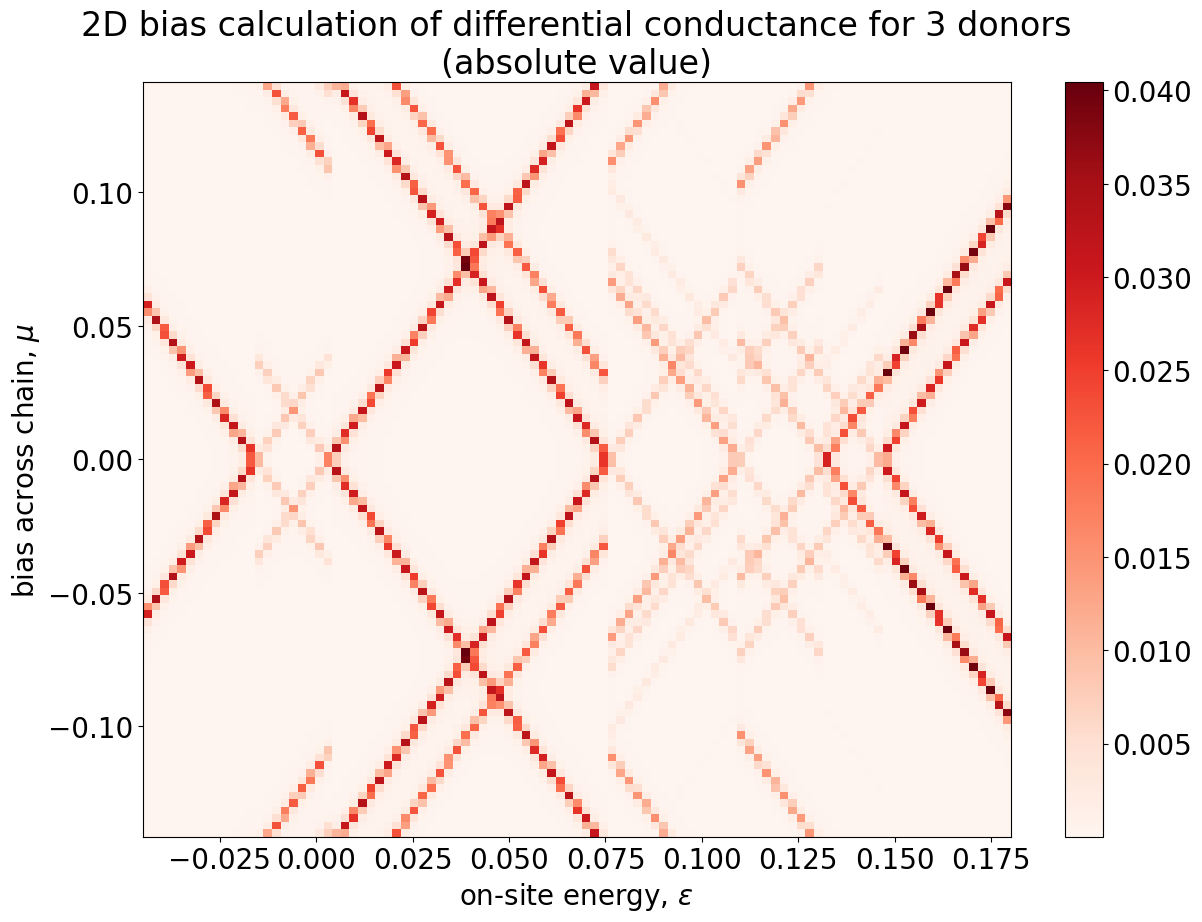

In [8]:
figure(figsize=(14,10),dpi=100)
raLims = [raErange_eV[0],raErange_eV[-1],raBias_eV[0],raBias_eV[-1]]
radIdV = (raCurrents2D_3donors[:nIs-1,:]-raCurrents2D_3donors[1:,:])/\
         (raBias_eV[1]-raBias_eV[0])
imshow(np.abs(radIdV),extent=raLims,cmap='Reds',aspect='auto')
title('2D bias calculation of differential conductance for 3 donors\n(absolute value)')
xlabel(r'on-site energy, $\epsilon$')
ylabel(r'bias across chain, $\mu$')
colorbar()

In [9]:
nDonors = 3
# Allocate space for the tunnel couplings
matTsNow = np.zeros([nDonors,nDonors])
raGammasL = np.zeros([nDonors])
raGammasR = np.zeros([nDonors])
# Fill in all the tunnel couplings (if you want to use different tunnel couplings, this
# is mostly where you'd change things)
for jIdx in np.arange(nDonors):
    raGammasL[jIdx] = (1.0e-3*fTunnel((jIdx+1)*raR_nm)[0])**2
    raGammasR[-1-jIdx] = (1.0e-3*fTunnel((jIdx+1)*raR_nm)[0])**2
    for kIdx in np.arange(nDonors):
        nDist = np.abs(jIdx-kIdx)
        if int(nDist)==1:
            matTsNow[jIdx,kIdx] = 1.0e-3*fTunnel(nDist*raR_nm)[0]
# Here's where I define the matrices for the embeddings
matGammaL = np.kron(np.diag(raGammasL),np.eye(2,dtype=np.complex128))
matGammaR = np.kron(np.diag(raGammasR),np.eye(2,dtype=np.complex128))


# And now actually calculate! Mix and match inputs here to adjust calculations as you need
raCurrents2D_3donors_nearestOnly = gcalcDoubleBiasSweep(matTsNow,matGammaL,matGammaR,raErange_eV,rm_eV,rU_eV,\
                                            raBias_eV,ftTimes,rEta_eV,rBeta_eVinv,3,nTrack=10)

0 2021-01-25 15:22:21.846192
10 2021-01-25 15:22:43.375049
20 2021-01-25 15:23:05.216941
30 2021-01-25 15:23:27.069743
40 2021-01-25 15:23:48.717500
50 2021-01-25 15:24:10.524883
60 2021-01-25 15:24:32.482467
70 2021-01-25 15:24:54.813434
80 2021-01-25 15:25:16.787160
90 2021-01-25 15:25:38.872191
100 2021-01-25 15:26:00.835669


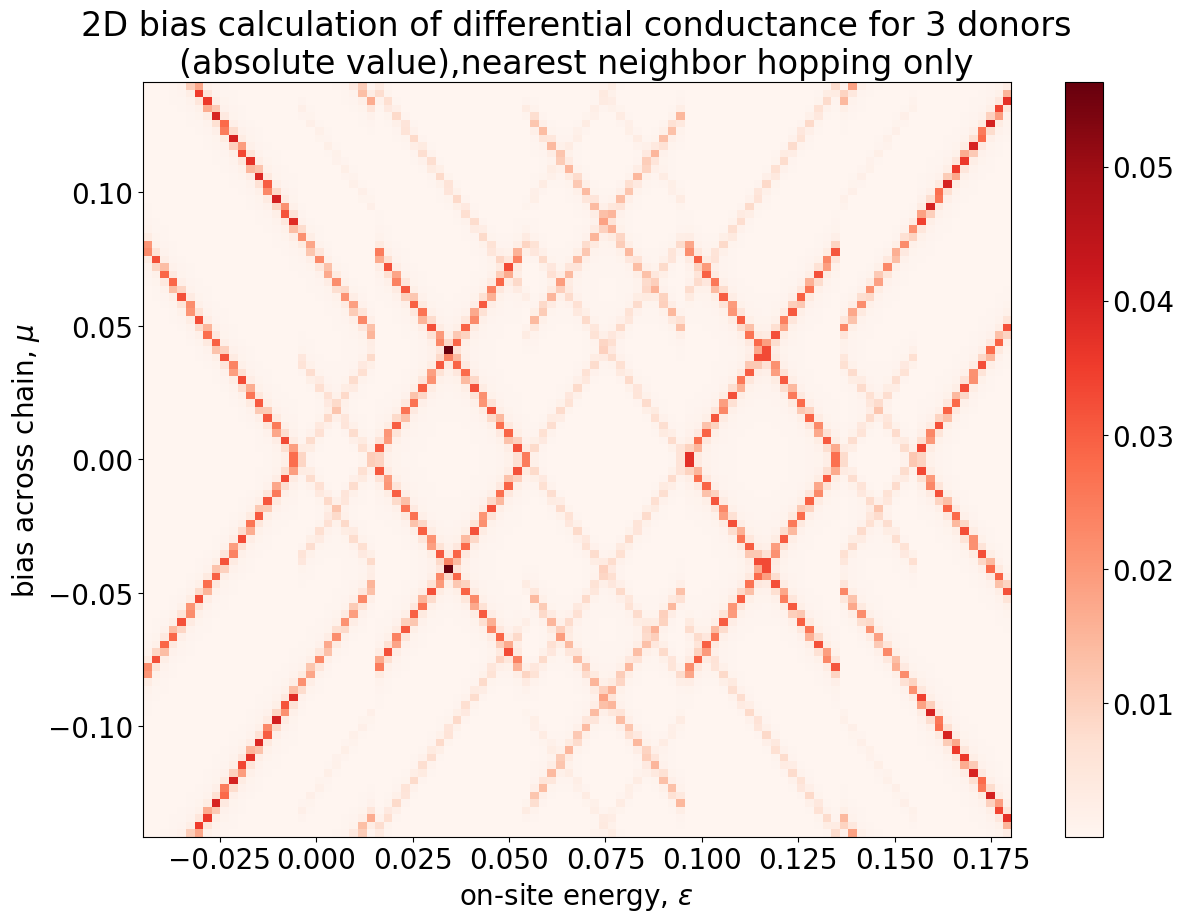

In [10]:
figure(figsize=(14,10),dpi=100)
raLims = [raErange_eV[0],raErange_eV[-1],raBias_eV[0],raBias_eV[-1]]
radIdV = (raCurrents2D_3donors_nearestOnly[:nIs-1,:]-raCurrents2D_3donors_nearestOnly[1:,:])/\
         (raBias_eV[1]-raBias_eV[0])
imshow(np.abs(radIdV),extent=raLims,cmap='Reds',aspect='auto')
title('2D bias calculation of differential conductance for 3 donors\n(absolute value), '+\
      'nearest neighbor hopping only')
xlabel(r'on-site energy, $\epsilon$')
ylabel(r'bias across chain, $\mu$')
colorbar()

In the above two calculations, you can see how the extra hoppings beyond just the nearest neighbor affect the calculation. With just nearest neighbor hoppings, (the second of the 3 donor calculations), the plot looks rather symmetric, suggesting some level of particle-hole symmetry. But with the extra hoppings included, that symmetry gets broken.

And those are the examples of running the code! There's a lot more that can be done with the code, e.g. just define the Hamiltonian for the donor chain, calculate the correlators between two operators, or create projectors that project the full many-body space down to only the space of occupancies you care about. Hopefully those are obvious from reading the code if they're needed, but if not then let me know!